# Maze Experiment Introduction

In this notebook, we will be running the MDP_Model on the Maze problem. This 2D simulation builds on a `gym-maze` package that can be found here: https://github.com/MattChanTK/gym-maze. Before beginning this simulation, please be sure to install the relevant packages on the github **Installation** section (pygame and numpy are also required)!

## Demonstration

First, a quick demonstration about what the game is. Essentially, there is a robot (circle) that starts on the blue start-point, then keeps taking steps (either with a designated policy or randomly), until it reaches the end point. Here is a simulation to demonstrate:

In [1]:
# Load Libraries
import numpy as np
import pandas as pd
import math
import random
import gym
import gym_maze

In [71]:
# Initializing the gym environment for a maze
env = gym.make("maze-sample-5x5-v0")

# Running the maze
observation = env.reset()
for _ in range(1000):
    
    env.render()
    action = env.action_space.sample() # your agent here (this takes random actions)
    observation, reward, done, info = env.step(action)
      
    if done:
      observation = env.reset()
env.close()

## Algorithm Goal

The goal on our end is to derive our dataset from the path that the robot takes. Every time it reaches a new coordinate, depending on whether the coordinate is the goal, the robot gets a "reward." With these datapoints, our algorithm should be able to learn an MDP to map out the optimal path through the maze!

## Dataset Creation

Loading relevant packages and functions - make sure to change the `sys.path.append` line with the relevant directory that contains the MDP Algorithm.

In [3]:
# Set Working Directory
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

import sys
# sys.path.append('/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/')
sys.path.append('/Users/Amine/Dropbox (MIT)/Research/Opioids/Opioids Git/Algorithm/')

#from MDPtools import *
from model import MDP_model
from maze_functions import createSamples, opt_model_trajectory, opt_maze_trajectory, plot_paths
from testing import cluster_size, next_clusters, training_value_error, purity, plot_features

Now selecting parameters: here, we decide how many times we want the robot to run through the maze (`N`), when we want to start a new run if the robot takes too long (`T_max`), and the maze that we want the robot to run through (`mazes[x]`, with x being a number from the dictionary).

`reseed`' is set to `True` if we want the robot to travel to a different location within each cell every time it moves, while `False` ensures that the robot will start at a certain place in the initial coordinate, but move to the exact same place in the next coordinate. 

`r` is a float between 0 and 1 indicating the randomness percentage. For instance, if `r = 1`, the robot will take steps in completely random directions 100% of the time, while if `r = 0.5`, it will take half of its steps in the optimal direction (gotten by solving the maze MDP), but the other half randomly. 

In [4]:
N = 50
T_max = 100
r = 0.4

# list of maze options to choose from:
mazes = {1: 'maze-v0',
         2: 'maze-sample-3x3-v0',
         3: 'maze-random-3x3-v0',
         4: 'maze-sample-5x5-v0',
         5: 'maze-random-5x5-v0',
         6: 'maze-sample-10x10-v0',
         7: 'maze-random-10x10-v0',
         8: 'maze-sample-100x100-v0',
         9: 'maze-random-100x100-v0',
         10: 'maze-random-10x10-plus-v0', # has portals 
         11: 'maze-random-20x20-plus-v0', # has portals 
         12: 'maze-random-30x30-plus-v0'} # has portals 

df = createSamples(N, T_max, mazes[2], r, reseed=True)
print(df)

     ID  TIME  FEATURE_0  FEATURE_1 ACTION      RISK  OG_CLUSTER
0     0     0   0.717054  -0.672437      1 -0.011111           0
1     0     1   0.625025  -1.548238      1 -0.011111           3
2     0     2   0.395032  -2.988051      3 -0.011111           6
3     0     3   0.764327  -2.779968      2 -0.011111           6
4     0     4   1.418320  -2.117272      1 -0.011111           7
..   ..   ...        ...        ...    ...       ...         ...
394  49     6   0.071113  -1.230862      1 -0.011111           3
395  49     7   0.035604  -2.076502      1 -0.011111           6
396  49     8   0.389114  -2.884978      2 -0.011111           6
397  49     9   1.804947  -2.572955      2 -0.011111           7
398  49    10   2.661728  -2.103832   None  1.000000           8

[399 rows x 7 columns]


The resulting `FEATURE_0` and `FEATURE_1` are the `x` and `y` coordinates respectively, while `ACTION` corresponds to the (`N`, `S`, `W`, `E`) directions. `RISK` is a reward of `1` if the endstate goal is reached, otherwise it is a negative factor of the maze size for all other locations. The robot does not change cells if it hits a wall, but if `reseed = True`, it can still change locations within the same cell. 

Here, we can visualize an example path that we are feeding as data into our algorithm. Note that it is not clear at all that there are grids or walls! The algorithm will train on these `N` paths to attempt to find the optimal policy. 

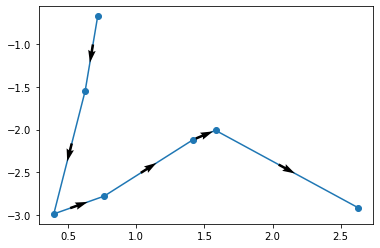

In [5]:
plot_paths(df, 1)

## Running the Algorithm

Now, we can run the algorithm on the generated dataset! First, we can set some parameters, including `max_k` which is the number of clusters we want to end with, and thus determines the number of iterations during the splitting process. Since initial clustering is based solely on `RISK`, and there are only two groups (end state and all others), there will only be two initial clusters. The expected optimal `max_k` should be the maze size. 

In [8]:
max_k = 9
clustering = 'Agglomerative'
n_clusters = None
distance_threshold = 0.5
random_state = 0
pfeatures = 2
actions = [0, 1, 2, 3]
h = -1
cv = 5
th = 0
classification = 'DecisionTreeClassifier' 
split_classifier_params = {'random_state':0}

Now, we can fit an algorithm model to this, using either `m.fit` or `m.fit_CV` (this one runs with `cv` rounds of cross validation, and takes the optimal split). `m.fit` with `optimize=True` will train the model on all the data, and retain the model with an optimal amount of splits.

Splitting... |#Clusters:2:   0%|          | 0/7 [00:00<?, ?it/s]

Clusters Initialized
      ID  TIME  FEATURE_0  FEATURE_1 ACTION      RISK  OG_CLUSTER  CLUSTER  \
0      0     0   0.096132   0.229068      3 -0.011111           0        0   
1      0     1   0.782131   0.583225      0 -0.011111           0        0   
2      0     2   0.740662   0.004201      1 -0.011111           0        0   
3      0     3   0.759403   1.158536      2 -0.011111           3        0   
4      0     4   0.163496   1.591413      3 -0.011111           3        0   
...   ..   ...        ...        ...    ...       ...         ...      ...   
3013  49    48   0.388233   1.201605      3 -0.011111           3        0   
3014  49    49   0.940092   1.065454      1 -0.011111           3        0   
3015  49    50   0.066645   2.080247      2 -0.011111           6        0   
3016  49    51   1.116739   2.548575      2 -0.011111           7        0   
3017  49    52   2.032827   2.165163   None  1.000000           8        1   

     NEXT_CLUSTER  
0               0  
1 

Splitting... |#Clusters:3:  14%|█▍        | 1/7 [00:02<00:13,  2.17s/it]

               NEXT_CLUSTER
CLUSTER ACTION             
0       0                 0
        1                 0
        2                 0
        3                 0
1       None            End
2       0                 2
        1                 2
        2                 1
        3                 3
3       0                 0
        1                 3
        2                 2
        3                 3


Splitting... |#Clusters:4:  29%|██▊       | 2/7 [00:04<00:11,  2.20s/it]

               NEXT_CLUSTER
CLUSTER ACTION             
0       0                 0
        1                 0
        2                 0
        3                 0
1       None            End
2       0                 2
        1                 2
        2                 1
        3                 3
3       0                 4
        1                 3
        2                 2
        3                 3
4       0                 0
        1                 3
        2                 4
        3                 4


Splitting... |#Clusters:5:  43%|████▎     | 3/7 [00:07<00:09,  2.33s/it]

               NEXT_CLUSTER
CLUSTER ACTION             
0       0                 0
        1                 0
        2                 0
        3                 0
1       None            End
2       0                 2
        1                 2
        2                 1
        3                 3
3       0                 4
        1                 3
        2                 2
        3                 3
4       0                 5
        1                 3
        2                 4
        3                 4
5       0                 5
        1                 4
        2                 0
        3                 5


Splitting... |#Clusters:6:  57%|█████▋    | 4/7 [00:09<00:07,  2.48s/it]

               NEXT_CLUSTER
CLUSTER ACTION             
0       0                 0
        1                 0
        2                 0
        3                 0
1       None            End
2       0                 2
        1                 2
        2                 1
        3                 3
3       0                 4
        1                 3
        2                 2
        3                 3
4       0                 5
        1                 3
        2                 4
        3                 4
5       0                 5
        1                 4
        2                 6
        3                 5
6       0                 6
        1                 6
        2                 0
        3                 5


Splitting... |#Clusters:7:  71%|███████▏  | 5/7 [00:12<00:05,  2.56s/it]

               NEXT_CLUSTER
CLUSTER ACTION             
0       0                 0
        1                 0
        2                 0
        3                 0
1       None            End
2       0                 2
        1                 2
        2                 1
        3                 3
3       0                 4
        1                 3
        2                 2
        3                 3
4       0                 5
        1                 3
        2                 4
        3                 4
5       0                 5
        1                 4
        2                 6
        3                 5
6       0                 6
        1                 6
        2                 7
        3                 5
7       0                 7
        1                 0
        2                 7
        3                 6


Splitting... |#Clusters:8:  86%|████████▌ | 6/7 [00:15<00:02,  2.58s/it]

               NEXT_CLUSTER
CLUSTER ACTION             
0       0                 0
        1                 0
        2                 8
        3                 0
1       None            End
2       0                 2
        1                 2
        2                 1
        3                 3
3       0                 4
        1                 3
        2                 2
        3                 3
4       0                 5
        1                 3
        2                 4
        3                 4
5       0                 5
        1                 4
        2                 6
        3                 5
6       0                 6
        1                 6
        2                 7
        3                 5
7       0                 7
        1                 8
        2                 7
        3                 6
8       0                 7
        1                 8
        2                 8
        3                 0


Splitting... |#Clusters:8:  86%|████████▌ | 6/7 [00:18<00:03,  3.03s/it]

Optimal # of clusters reached


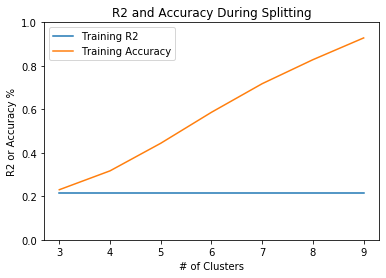

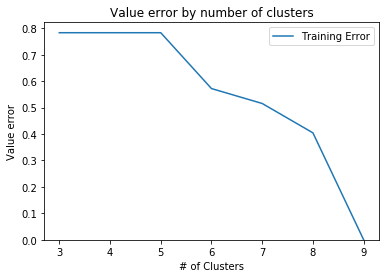

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [9]:
m = MDP_model()
m.fit(df, # df: dataframe in the format ['ID', 'TIME', ...features..., 'RISK', 'ACTION']
    pfeatures, # int: number of features
    h, # int: time horizon (# of actions we want to optimize)
    max_k, # int: number of iterations
    distance_threshold, # clustering diameter for Agglomerative clustering
    cv, # number for cross validation
    th, # splitting threshold
    classification, # classification method
    split_classifier_params, # classification parameters
    clustering,# clustering method from Agglomerative, KMeans, and Birch
    n_clusters, # number of clusters for KMeans
    random_state,
    plot=True,
    optimize=False)

## Visualizing Results

If `plot = True` above, you should see that the final Value error drops to close to 0 when the number of clusters is 9, which is what should be the case for a 3 by 3 maze! Here is another visualization of how the correct clusters should be:

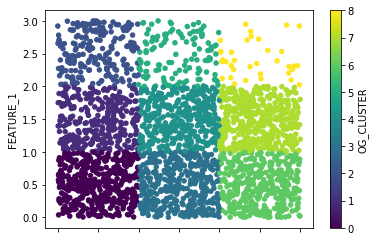

In [6]:
plot_features(m.df_trained, 'FEATURE_0', 'FEATURE_1', c='OG_CLUSTER')

And here is a visualization of how the algorithm currently views where the clusters are:

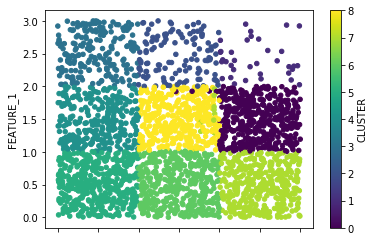

In [7]:
plot_features(m.df_trained, 'FEATURE_0', 'FEATURE_1', c='CLUSTER')

We can see that the clustering may not be completely perfect, and to quantify this, we can look at both the `training_error` and `purity`. The dataframe created by `training_error` tells us how the error was when we had that many clusters, so the error corresponding to `Clusters = 9` should be the lowest.

In [8]:
m.training_error

,Clusters,Error
0,3,8.459562e-01
1,4,8.459562e-01
2,5,8.459562e-01
3,6,6.857689e-01
4,7,5.895740e-01
5,8,1.245022e+01
6,9,1.365890e-15


The `purity` compares how much of the new clustering was made up of points from the same original cluster. We can see the percentage breakdown here - the higher the percentage, the better! 

In [9]:
purity(m.df_trained)

CLUSTER
0    0.991131
1    1.000000
2    0.991597
3    1.000000
4    1.000000
5    0.997658
6    0.985577
7    0.973615
8    1.000000
Name: Purity, dtype: float64

## Comparing Solutions

We can see how well our model learned the maze by comparing the optimal path it found to the real solution. The real solution is found by getting the actual transition and reward matrices of the maze, then solving this MDP to get the optimal policy. This is what the correct path should be:

Optimal Value: [46.0752792  45.1426625  44.22869814 47.02692889 42.4552417  43.33301307
 47.998      48.98888889 50.        ]
Optimal Policy: [1 3 3 1 2 0 2 2 0]


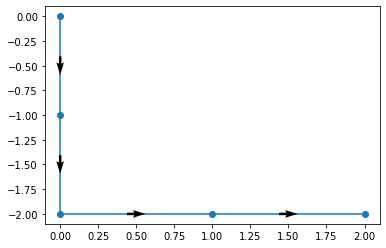

(array([0., 0., 0., 1., 2.]), array([-0., -1., -2., -2., -2.]))

In [6]:
opt_maze_trajectory(mazes[2])

And here, this is what our trained model found the solution to be (remember, our algorithm only got the messy data paths, and did not even know that there were 9 grid spaces!):

Optimal Value: [3.67185789e-01 1.00000000e+00 8.88888889e-01 7.88888889e-01
 6.98888889e-01 6.17888889e-01 5.44988889e-01 4.79378889e-01
 4.20329889e-01 2.73328220e-10]
Optimal Policy: [2 0 2 2 1 1 3 3 0 0]


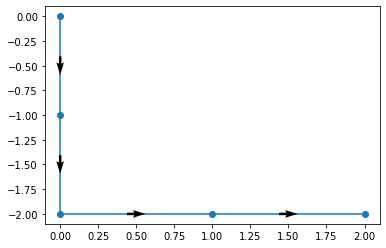

(array([0., 0., 0., 1., 2.]), array([-0., -1., -2., -2., -2.]))

In [10]:
opt_model_trajectory(m, mazes[2])

# Time for Bigger Mazes!

We can generate bigger mazes using the same method as above! Then, we will test to see if the optimal policy found by the maze is the same as the real optimal policy. 

#### Importing Modules

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

import sys
sys.path.append('/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/')

from model import MDP_model
from maze_functions import createSamples, opt_maze_trajectory, opt_model_trajectory, policy_accuracy, \
    get_maze_transition
from testing import cluster_size, next_clusters, training_value_error, purity, plot_features, testing_value_error

mazes = {1: 'maze-v0',
         2: 'maze-sample-3x3-v0',
         3: 'maze-random-3x3-v0',
         4: 'maze-sample-5x5-v0',
         5: 'maze-random-5x5-v0',
         6: 'maze-sample-10x10-v0',
         7: 'maze-random-10x10-v0',
         8: 'maze-sample-100x100-v0',
         9: 'maze-random-100x100-v0',
         10: 'maze-random-10x10-plus-v0', # has portals 
         11: 'maze-random-20x20-plus-v0', # has portals 
         12: 'maze-random-30x30-plus-v0'} # has portals 

#### Creating Samples

In [32]:
# Setting Parameters
N = 50
T_max = 20
r = 0.4
maze = mazes[4]

In [33]:
df = createSamples(N, T_max, maze, r, reseed=True)
df

,ID,TIME,FEATURE_0,FEATURE_1,ACTION,RISK,OG_CLUSTER
0,0,0,0.192705,-0.696059,2,-0.004,0
1,0,1,1.075503,-0.733781,2,-0.004,1
2,0,2,2.627586,-0.762871,1,-0.004,2
3,0,3,2.167695,-1.556027,0,-0.004,7
4,0,4,2.967902,-0.277084,1,-0.004,2
...,...,...,...,...,...,...,...
988,49,15,3.340626,-4.514460,0,-0.004,23
989,49,16,3.381462,-3.861337,0,-0.004,18
990,49,17,3.925452,-2.618186,0,-0.004,13
991,49,18,3.572225,-1.616019,2,-0.004,8


That's how the transition data looks like:

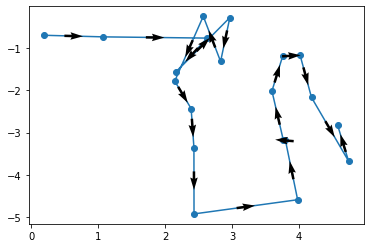

In [73]:
plot_paths(df,1)

Checking how many points actually reach the end: 

In [34]:
df.loc[df['ACTION']=='None']['ID'].count()

16

#### Fitting to Algorithm

Clusters Initialized
     ID  TIME  FEATURE_0  FEATURE_1 ACTION   RISK  OG_CLUSTER  CLUSTER  \
0     0     0   0.192705  -0.696059      2 -0.004           0        0   
1     0     1   1.075503  -0.733781      2 -0.004           1        0   
2     0     2   2.627586  -0.762871      1 -0.004           2        0   
3     0     3   2.167695  -1.556027      0 -0.004           7        0   
4     0     4   2.967902  -0.277084      1 -0.004           2        0   
..   ..   ...        ...        ...    ...    ...         ...      ...   
988  49    15   3.340626  -4.514460      0 -0.004          23        0   
989  49    16   3.381462  -3.861337      0 -0.004          18        0   
990  49    17   3.925452  -2.618186      0 -0.004          13        0   
991  49    18   3.572225  -1.616019      2 -0.004           8        0   
992  49    19   4.631051  -1.670607      1 -0.004           9        0   

    NEXT_CLUSTER  
0              0  
1              0  
2              0  
3             


Splitting...:   0%|                                                                             | 0/14 [00:00<?, ?it/s]
Splitting... |#Clusters:2:   0%|                                                                | 0/14 [00:00<?, ?it/s]
Splitting... |#Clusters:2:   7%|████                                                    | 1/14 [00:00<00:08,  1.45it/s]
Splitting... |#Clusters:3:   7%|████                                                    | 1/14 [00:00<00:08,  1.45it/s]
Splitting... |#Clusters:3:  14%|████████                                                | 2/14 [00:01<00:08,  1.41it/s]
Splitting... |#Clusters:4:  14%|████████                                                | 2/14 [00:01<00:08,  1.41it/s]
Splitting... |#Clusters:4:  21%|████████████                                            | 3/14 [00:02<00:08,  1.36it/s]
Splitting... |#Clusters:5:  21%|████████████                                            | 3/14 [00:02<00:08,  1.36it/s]
Splitting... |#Clusters:5:  29%|███████


Splitting... |#Clusters:12:  79%|██████████████████████████████████████████▍           | 11/14 [00:10<00:03,  1.09s/it]
Splitting... |#Clusters:13:  79%|██████████████████████████████████████████▍           | 11/14 [00:10<00:03,  1.09s/it]
Splitting... |#Clusters:13:  86%|██████████████████████████████████████████████▎       | 12/14 [00:11<00:02,  1.17s/it]
Splitting... |#Clusters:14:  86%|██████████████████████████████████████████████▎       | 12/14 [00:11<00:02,  1.17s/it]


Splitting... |#Clusters:14:  93%|██████████████████████████████████████████████████▏   | 13/14 [00:13<00:01,  1.28s/it]
Splitting... |#Clusters:15:  93%|██████████████████████████████████████████████████▏   | 13/14 [00:13<00:01,  1.28s/it]

Optimal # of clusters reached


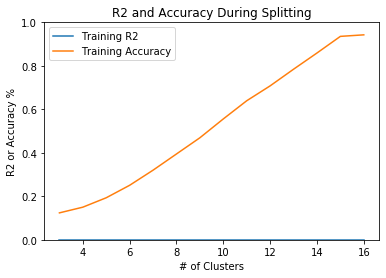

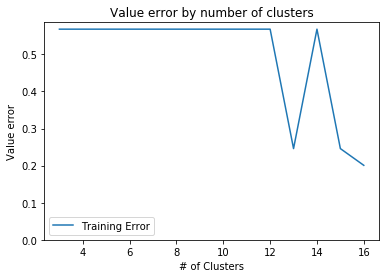

C:\Users\Amine\.julia\conda\3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [35]:
# Setting parameters for model fitting
max_k = 16
#classification ='AdaBoostClassifier'
classification = 'DecisionTreeClassifier'
#classification = 'RandomForestClassifier'
split_classifier_params = {'random_state':0, 'max_depth':2}
clustering = 'Agglomerative'
n_clusters = None
distance_threshold = 0.5
random_state = 0
pfeatures = 2
actions = [0, 1, 2, 3]
h = -1
cv = 5
th = 0

m = MDP_model()
m.fit(df, # df: dataframe in the format ['ID', 'TIME', ...features..., 'RISK', 'ACTION']
    pfeatures, # int: number of features
    h, # int: time horizon (# of actions we want to optimize)
    max_k, # int: number of iterations
    distance_threshold, # clustering diameter for Agglomerative clustering
    cv, # number for cross validation
    th, # splitting threshold
    classification, # classification method
    split_classifier_params, # classifier params
    clustering,# clustering method from Agglomerative, KMeans, and Birch
    n_clusters, # number of clusters for KMeans
    random_state,
    plot=True,
    optimize=False)

#### Observing Policies

First, let's see what the clustering that the model found actually looks like!

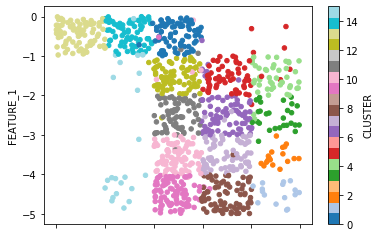

In [37]:
plot_features(m.df_trained, 'FEATURE_0', 'FEATURE_1', 'CLUSTER')

And compare it with a clustering with the actual cells of the Maze.

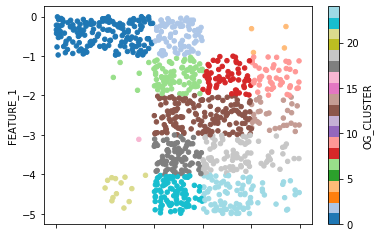

In [38]:
plot_features(m.df_trained, 'FEATURE_0', 'FEATURE_1', 'OG_CLUSTER')

In [49]:
def plot_features(df, x, y, c='CLUSTER'):
    df.plot.scatter(x=x,
                      y=y,
                      c=c,
                      colormap='tab20')
#    import seaborn as sns
#    sns.pairplot(x_vars=["FEATURE_1"], y_vars=["FEATURE_2"], data=df, hue="OG_CLUSTER", height=5)
    plt.show()

Now, let's see what the optimal policy our model learns is:

Optimal Value: [2.53726718e-01 1.00000000e+00 8.96000000e-01 8.02400000e-01
 7.18160000e-01 6.42344000e-01 5.74109600e-01 5.12698640e-01
 4.57428776e-01 4.07685899e-01 3.62917309e-01 3.22625578e-01
 2.86363020e-01 1.97918642e-01 2.24354046e-01 3.62917309e-01
 1.99256272e-10 0.00000000e+00]
Optimal Policy: [1 0 1 1 1 2 0 0 0 2 1 1 1 2 2 2 0 0]


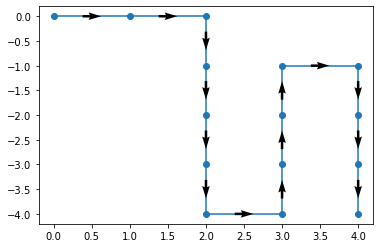

(array([0., 1., 2., 2., 2., 2., 2., 3., 3., 3., 3., 4., 4., 4., 4.]),
 array([-0.,  0.,  0., -1., -2., -3., -4., -4., -3., -2., -1., -1., -2.,
        -3., -4.]))

In [65]:
opt_model_trajectory(m, maze, 7, 0.7)

And here is an actual simulation of a point through the maze by taking the found optimal policy:

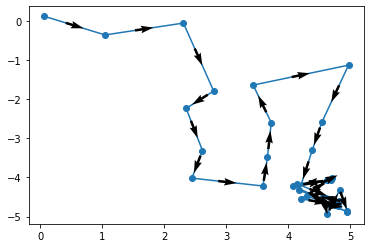

(array([0.06303001, 1.04511845, 2.30812333, 2.79603721, 2.35240416,
        2.61526301, 2.44580504, 3.59059738, 3.66362855, 3.72469067,
        3.43295431, 4.97065665, 4.54070739, 4.3834111 , 4.1781276 ,
        4.94144352, 4.29708597, 4.61683904, 4.70390079, 4.20091846,
        4.74565446, 4.6688848 , 4.80026943, 4.07916233, 4.69553844,
        4.13670046, 4.82410249, 4.55661376, 4.62794199, 4.82877891,
        4.95269228]),
 array([ 0.12270036, -0.35583385, -0.05186758, -1.78859866, -2.23419354,
        -3.31146086, -4.01823737, -4.21931592, -3.47802621, -2.5986689 ,
        -1.63796292, -1.12809003, -2.58843056, -3.31014531, -4.32368921,
        -4.87312001, -4.46986008, -4.07783903, -4.013463  , -4.54678837,
        -4.69369105, -4.70901027, -4.73838868, -4.22103024, -4.06968124,
        -4.16301117, -4.59954234, -4.49626931, -4.93298392, -4.32445289,
        -4.85909489]))

In [75]:
f = get_maze_transition(maze)
x0= np.random.rand(2)
m.opt_model_trajectory(x0, f)

Going through each point in the training data set, here is how many (by percentage) our optimal policy actually returned the correct action for. This is essentially the training accuracy:

In [62]:
policy_accuracy(m, maze)

Optimal Value: [7.04370331e-01 7.22826868e-01 7.41660069e-01 8.84704957e-01
 9.06841793e-01 6.51186120e-01 7.04370331e-01 7.60877622e-01
 9.06841793e-01 9.29430401e-01 6.68557266e-01 6.86282924e-01
 7.80487369e-01 8.84704957e-01 9.52480001e-01 7.60877622e-01
 7.80487369e-01 8.00497316e-01 8.63010858e-01 9.76000001e-01
 7.41660069e-01 8.00497316e-01 8.20915628e-01 8.41750641e-01
 1.00000000e+00 9.55885364e-10]
Optimal Policy: [2 2 1 2 1 1 0 1 2 1 2 0 1 0 1 2 1 1 0 1 0 2 2 0 0 0]


0.9798590130916415

Now, we will generate a new unseen test set using optimal parameters, and see how well the model does. This is the testing accuracy. 

In [27]:
# There seems to be an error!!! testing accuracy seems to be 0 for bad models...? Is it because we still take a 
# good action (from optimal policy which is df_test), and not the trained model's optimal policy which is wrong? 
# But why would trained model's optimal policy be wrong if P_df and R_df are right enough to give good s and a 
# transition predictions when testing?? Bad clustering for beginning clusters, better clustering for ending clusters
# and the optimal action leads us to those ending clusters via a different route
df_test = createSamples(50, T_max, maze, 0.3, reseed=True)
testing_value_error(df_test, m.df_trained, m.m, m.pfeatures, relative=False, h=-1)

2.7755575615628915e-18

In [89]:
m.m.predict(np.array((0.5, -0.5)).reshape(1, -1))

array([15])

In [22]:
m.pi

array([1, 0, 1, 1, 1, 2, 0, 0, 0, 2, 1, 1, 1, 2, 2, 2, 0, 0], dtype=int64)

In [82]:
from testing import get_MDP
def testing_value_error(df_test, df_new, model, pfeatures,relative=False,h=5):
    E_v = 0
    P_df,R_df = get_MDP(df_new)
    print(P_df)
    print(R_df)
    df2 = df_test.reset_index()
    df2 = df2.groupby(['ID']).first()
    N_test = df2.shape[0]
        
    df_test['CLUSTER'] = model.predict(df_test.iloc[:, 2:2+pfeatures])
    for i in range(N_test):
        # initializing index of first state for each ID
        index = df2['index'].iloc[i]
        cont = True
        
        if h == -1:
            t = 0

        else:
            H = -1
            # Computing Horizon H of ID i
            while cont:
                H+= 1
                try: 
                    df_test['ID'].loc[index+H+1]
                except:
                    break
                if df_test['ID'].loc[index+H] != df_test['ID'].loc[index+H+1]:
                    break
            t = H-h
        
        v_true = 0
        v_estim = 0
        s = df_test['CLUSTER'].loc[index + t]
        a = df_test['ACTION'].loc[index + t]
        
        # predicting path of each ID
        while cont:
            v_true = v_true + df_test['RISK'].loc[index + t]
            v_estim = v_estim + R_df.loc[s]
            print('s', 'a', s, a)
            #print('true', v_true, 'estim', v_estim)
            try: 
                df_test['ID'].loc[index+t+1]
            except:
                break
            if df_test['ID'].loc[index+t] != df_test['ID'].loc[index+t+1]:
                break 
            try:
                s = P_df.loc[s,a].values[0]
            # error raises in case we never saw a given transition in the data
            except TypeError:
                print('WARNING: In training value evaluation, trying to predict next state from state',s,'taking action',a,', but this transition is never seen in the data. Data point:',i,t)
            
            
            t += 1
            a = df_test['ACTION'].loc[index + t]
        if relative:
            E_v = E_v + ((v_true-v_estim)/v_true)**2
        else:
            E_v = E_v + (v_true-v_estim)**2

    E_v = (E_v/N_test)
    return np.sqrt(E_v)

In [68]:
pred = m.m.predict(m.df_trained[['FEATURE_0', 'FEATURE_1']])

In [69]:
from sklearn.metrics import accuracy_score
accuracy_score(pred, m.df_trained['CLUSTER'])

0.9353448275862069

And compare this with the true optimal policy:

Optimal Value: [37.63282546 38.40492394 39.19277953 45.176824   46.10288163 35.40795266
 37.63282546 39.99671381 46.10288163 47.0478384  36.13464557 36.87616895
 40.8170549  45.176824   48.01208    39.99671381 40.8170549  41.65413766
 44.26928752 48.996      39.19277953 41.65413766 42.50830373 43.37990177
 50.        ]
Optimal Policy: [2 2 1 2 1 1 0 1 2 1 2 0 1 0 1 2 1 1 0 1 0 2 2 0 1]


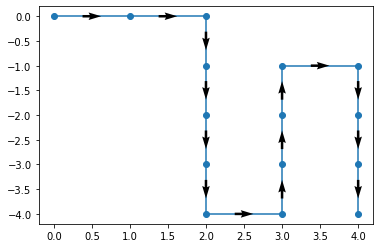

(array([0., 1., 2., 2., 2., 2., 2., 3., 3., 3., 3., 4., 4., 4., 4.]),
 array([-0.,  0.,  0., -1., -2., -3., -4., -4., -3., -2., -1., -1., -2.,
        -3., -4.]))

In [13]:
opt_maze_trajectory(maze)

In [54]:
m.R

array([[-4.e-03,  1.e+00, -4.e-03, -4.e-03, -4.e-03, -4.e-03, -4.e-03,
        -4.e-03, -4.e-03, -4.e-03, -4.e-03, -4.e-03, -4.e-03, -4.e-03,
        -4.e-03, -4.e-03,  0.e+00, -1.e+02],
       [-4.e-03,  1.e+00, -4.e-03, -4.e-03, -4.e-03, -4.e-03, -4.e-03,
        -4.e-03, -4.e-03, -4.e-03, -4.e-03, -4.e-03, -4.e-03, -4.e-03,
        -4.e-03, -4.e-03,  0.e+00, -1.e+02],
       [-4.e-03,  1.e+00, -4.e-03, -4.e-03, -4.e-03, -4.e-03, -4.e-03,
        -4.e-03, -4.e-03, -4.e-03, -4.e-03, -4.e-03, -4.e-03, -4.e-03,
        -4.e-03, -4.e-03,  0.e+00, -1.e+02],
       [-4.e-03,  1.e+00, -4.e-03, -4.e-03, -4.e-03, -4.e-03, -4.e-03,
        -4.e-03, -4.e-03, -4.e-03, -4.e-03, -4.e-03, -4.e-03, -4.e-03,
        -4.e-03, -4.e-03,  0.e+00, -1.e+02]])